# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nbformat
from nbconvert import HTMLExporter
from IPython.display import display, Javascript
import seaborn as sns
import copy
import os

# How to use
This is a notebook to compare and visualize results of two benchamrks of the same type.
Before running the notebook, please provide a benchamrk results csv files paths as a `path1` and `path2` in User input section. You can also specify a name of resulting HTML file as a `filename` in the same section and name the benchmarks by modifying `benchmark_1_name` and `benchmark_2_name`. To perform the analysis provide the neccessary user input and run the notebook.
 By executing final section of the notebook, you can convert the results to HTML and save them in `data_analysis_results` folder. If you want to add notes and comments, just convert the given HTML to PDF in you browser. 
 ### PLEASE REMEMBER TO SAVE NOTEBOOK BEFORE EXPORTING IF TO HTML!!!

# User input

## Defining benchmark file path

In [2]:
#path1 = "benchmark_results/2024-11-15_14-56-01/small_automatic_benchmark_results_2024-11-15_14-56-01.csv"
#path2 = "benchmark_results/2024-11-12_20-31-08/small_automatic_benchmark_results_2024-11-12_20-31-08.csv"
#path1 = "benchmark_results/2024-12-03_17-21-02/small_automatic_benchmark_results_2024-12-03_17-21-02.csv" #nn
#path2 = "benchmark_results/2024-12-04_00-13-58/small_automatic_benchmark_results_2024-12-04_00-13-58.csv" #small nn
# path2 = "benchmark_results/2024-11-15_22-15-46/small_automatic_benchmark_results_2024-11-15_22-15-46.csv" # added discovered stops dict
#path2 = "benchmark_results/2024-11-15_22-47-11/small_automatic_benchmark_results_2024-11-15_22-47-11.csv" # no visited stops set
#path2 = "benchmark_results/2024-11-16_00-03-08/small_automatic_benchmark_results_2024-11-16_00-03-08.csv" # eucliden vanila
path1 = "benchmark_results/2024-12-04_23-24-39/small_automatic_benchmark_results_2024-12-04_23-24-39.csv" # Jakub version nn
#path2 = "benchmark_results/2024-12-05_00-45-42/small_automatic_benchmark_results_2024-12-05_00-45-42.csv" # Jakub version euclidean
#path2 = "benchmark_results/2024-12-05_15-36-24/small_automatic_benchmark_results_2024-12-05_15-36-24.csv" # corrected euclidean
path2 = "benchmark_results/2024-12-05_15-46-41/small_automatic_benchmark_results_2024-12-05_15-46-41.csv" # euclidean max speed 72 km/h

## (optional) Define data analysis file name

In [3]:
benchmark_2_name = "euclidean"
benchmark_1_name = "nn"
filename = None

In [4]:
if benchmark_1_name is None:
    benchmark_1_name = path1.split("/")[-1]
    benchmark_1_name = benchmark_1_name.split(".")[0]
if benchmark_2_name is None:
    benchmark_2_name = path2.split("/")[-1]
    benchmark_2_name = benchmark_2_name.split(".")[0]
if filename is None:
    filename = benchmark_1_name + "_vs_" + benchmark_2_name + "_analysis"

# Preprocessing

In [5]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return None
    h, m, s = map(int, time_str.split(':'))
    return h * 60 + m + s / 60

def seconds_to_miliseconds(seconds):
    return seconds * 1000

In [6]:
s_to_ms_columns = [
    'prospecting_time',
    'start_walking_times_time',
    'destination_walking_times_time',
    'precomputed_heurisitc_times_time',
    'planner_initialization_time',
    'get_next_trips_time_total',
    'plan_compute_heurstic_time_total',
    'plan_compute_actual_time_total',
    'find_plans_time_total',
    'plans_queue_operations_time',
    'plan_accepting_time',
    'extended_plans_initialization_time',
]

def process_df(df1):
    df1['found route duration (min)'] = df1['found route duration'].apply(time_to_minutes)
    df1['Label'] = df1['Start name'] + ' -> ' + df1['Destination Name'] + '\n (' + df1['Start Time'] + ' '+ df1['Day of week'] + ')'

    for c in s_to_ms_columns:
        if c in df1:
            df1[c] = df1[c].apply(seconds_to_miliseconds)

    return df1

In [7]:
df1 = pd.read_csv(path1, encoding = "ISO-8859-2")
df2 = pd.read_csv(path2, encoding = "ISO-8859-2")

df1 = process_df(df1)
df2 = process_df(df2)

df1['difference (min)'] = df2['found route duration (min)'] - df1['found route duration (min)']
df1['difference_find_plans_time'] = df2['find_plans_time_total'] - df1['find_plans_time_total']

num_rows = len(df1)
fig_height = num_rows / 3.8


# Plots

In [8]:
def compare_columns(column_name, title, xlabel, ax, show_labels=True):
    label_column='Label'
    ylabel='Route',
    df1[f'difference_{column_name}'] = df2[column_name] - df1[column_name]

    df1['Label'] = df1[label_column]

    bars = ax.barh(df1['Label'], df1[f'difference_{column_name}'].fillna(0), color=['green' if x > 0 else 'red' if x < 0 else 'gray' for x in df1[f'difference_{column_name}'].fillna(0)], linewidth=1.5)

    for bar in bars:
        bar.set_edgecolor('white')
        bar.set_linewidth(1)
        bar.set_path_effects([])
        bar.set_clip_on(False)
        bar.set_capstyle('round')

    if show_labels:
        #ax.set_ylabel(ylabel)
        ax.set_yticklabels(df1['Label'], fontsize=8)
    else:
        ax.set_yticklabels([])

    ax.set_xlabel(xlabel)
    ax.set_title(title)

    for i, (bar, diff) in enumerate(zip(bars, df1[f'difference_{column_name}'])):
        xval = bar.get_width()
        offset = 0 
        color = 'green' if xval > 0 else 'red' if xval < 0 else 'gray'
        if pd.isna(diff):
            ax.text(0, bar.get_y() + bar.get_height()/2, 'NA', ha='center', va='center', color='black', fontsize=10, fontweight='bold')
        #else:
            #if xval > 0:
             #   ax.text(xval + offset, bar.get_y() + bar.get_height()/2, round(xval), ha='left', va='center', color='black', fontsize=10, fontweight='bold')
            #else:
             #   ax.text(xval - offset, bar.get_y() + bar.get_height()/2, round(xval), ha='right', va='center', color='black', fontsize=10, fontweight='bold')

    ax.grid(axis='x', linestyle='--', alpha=0.7)

## Performance comparison

C:\Users\User\AppData\Local\Temp\ipykernel_24608\2223242385.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df1['Label'], fontsize=8)
C:\Users\User\AppData\Local\Temp\ipykernel_24608\2223242385.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df1['Label'], fontsize=8)
C:\Users\User\AppData\Local\Temp\ipykernel_24608\2223242385.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(df1['Label'], fontsize=8)


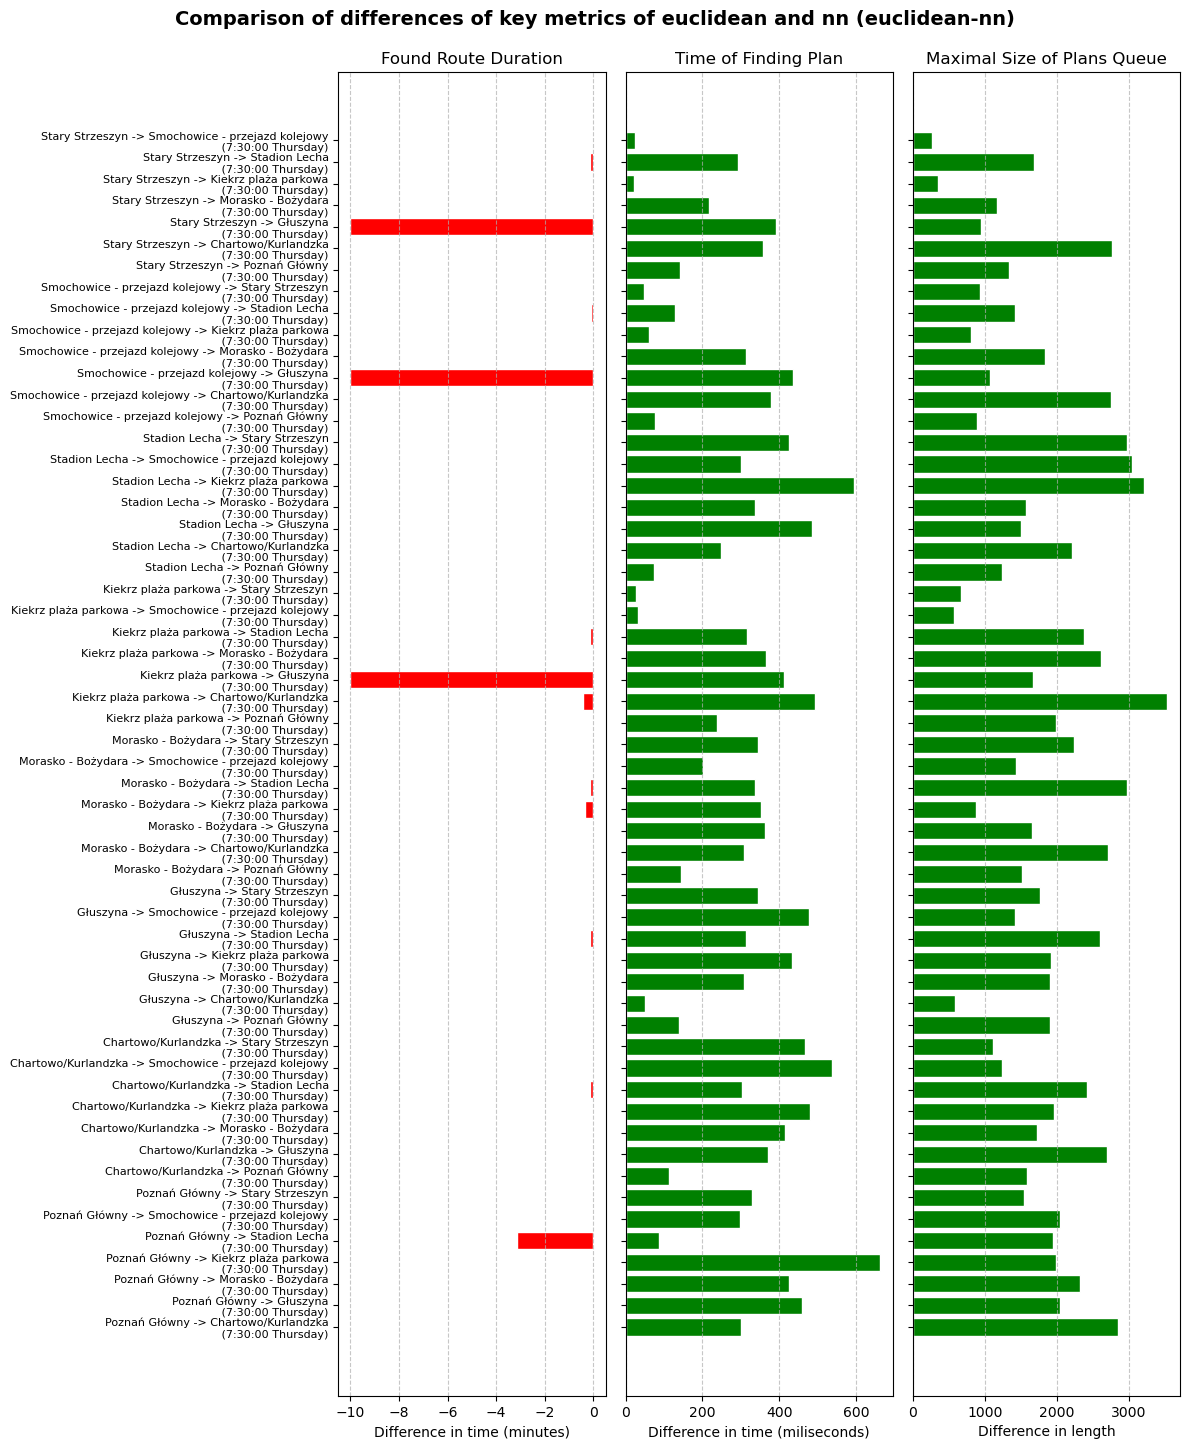

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, fig_height), sharey=True)
compare_columns(
    column_name='found route duration (min)', 
    title='Found Route Duration', 
    xlabel='Difference in time (minutes)', 
    ax=axes[0],
)

compare_columns( 
    column_name='find_plans_time_total', 
    title='Time of Finding Plan', 
    xlabel='Difference in time (miliseconds)', 
    ax=axes[1],
)

compare_columns( 
    column_name='plans_queue_max_size', 
    title='Maximal Size of Plans Queue', 
    xlabel='Difference in length', 
    ax=axes[2],
)

fig.suptitle(f'Comparison of differences of key metrics of {benchmark_2_name} and {benchmark_1_name} ({benchmark_2_name}-{benchmark_1_name})\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Searching time components

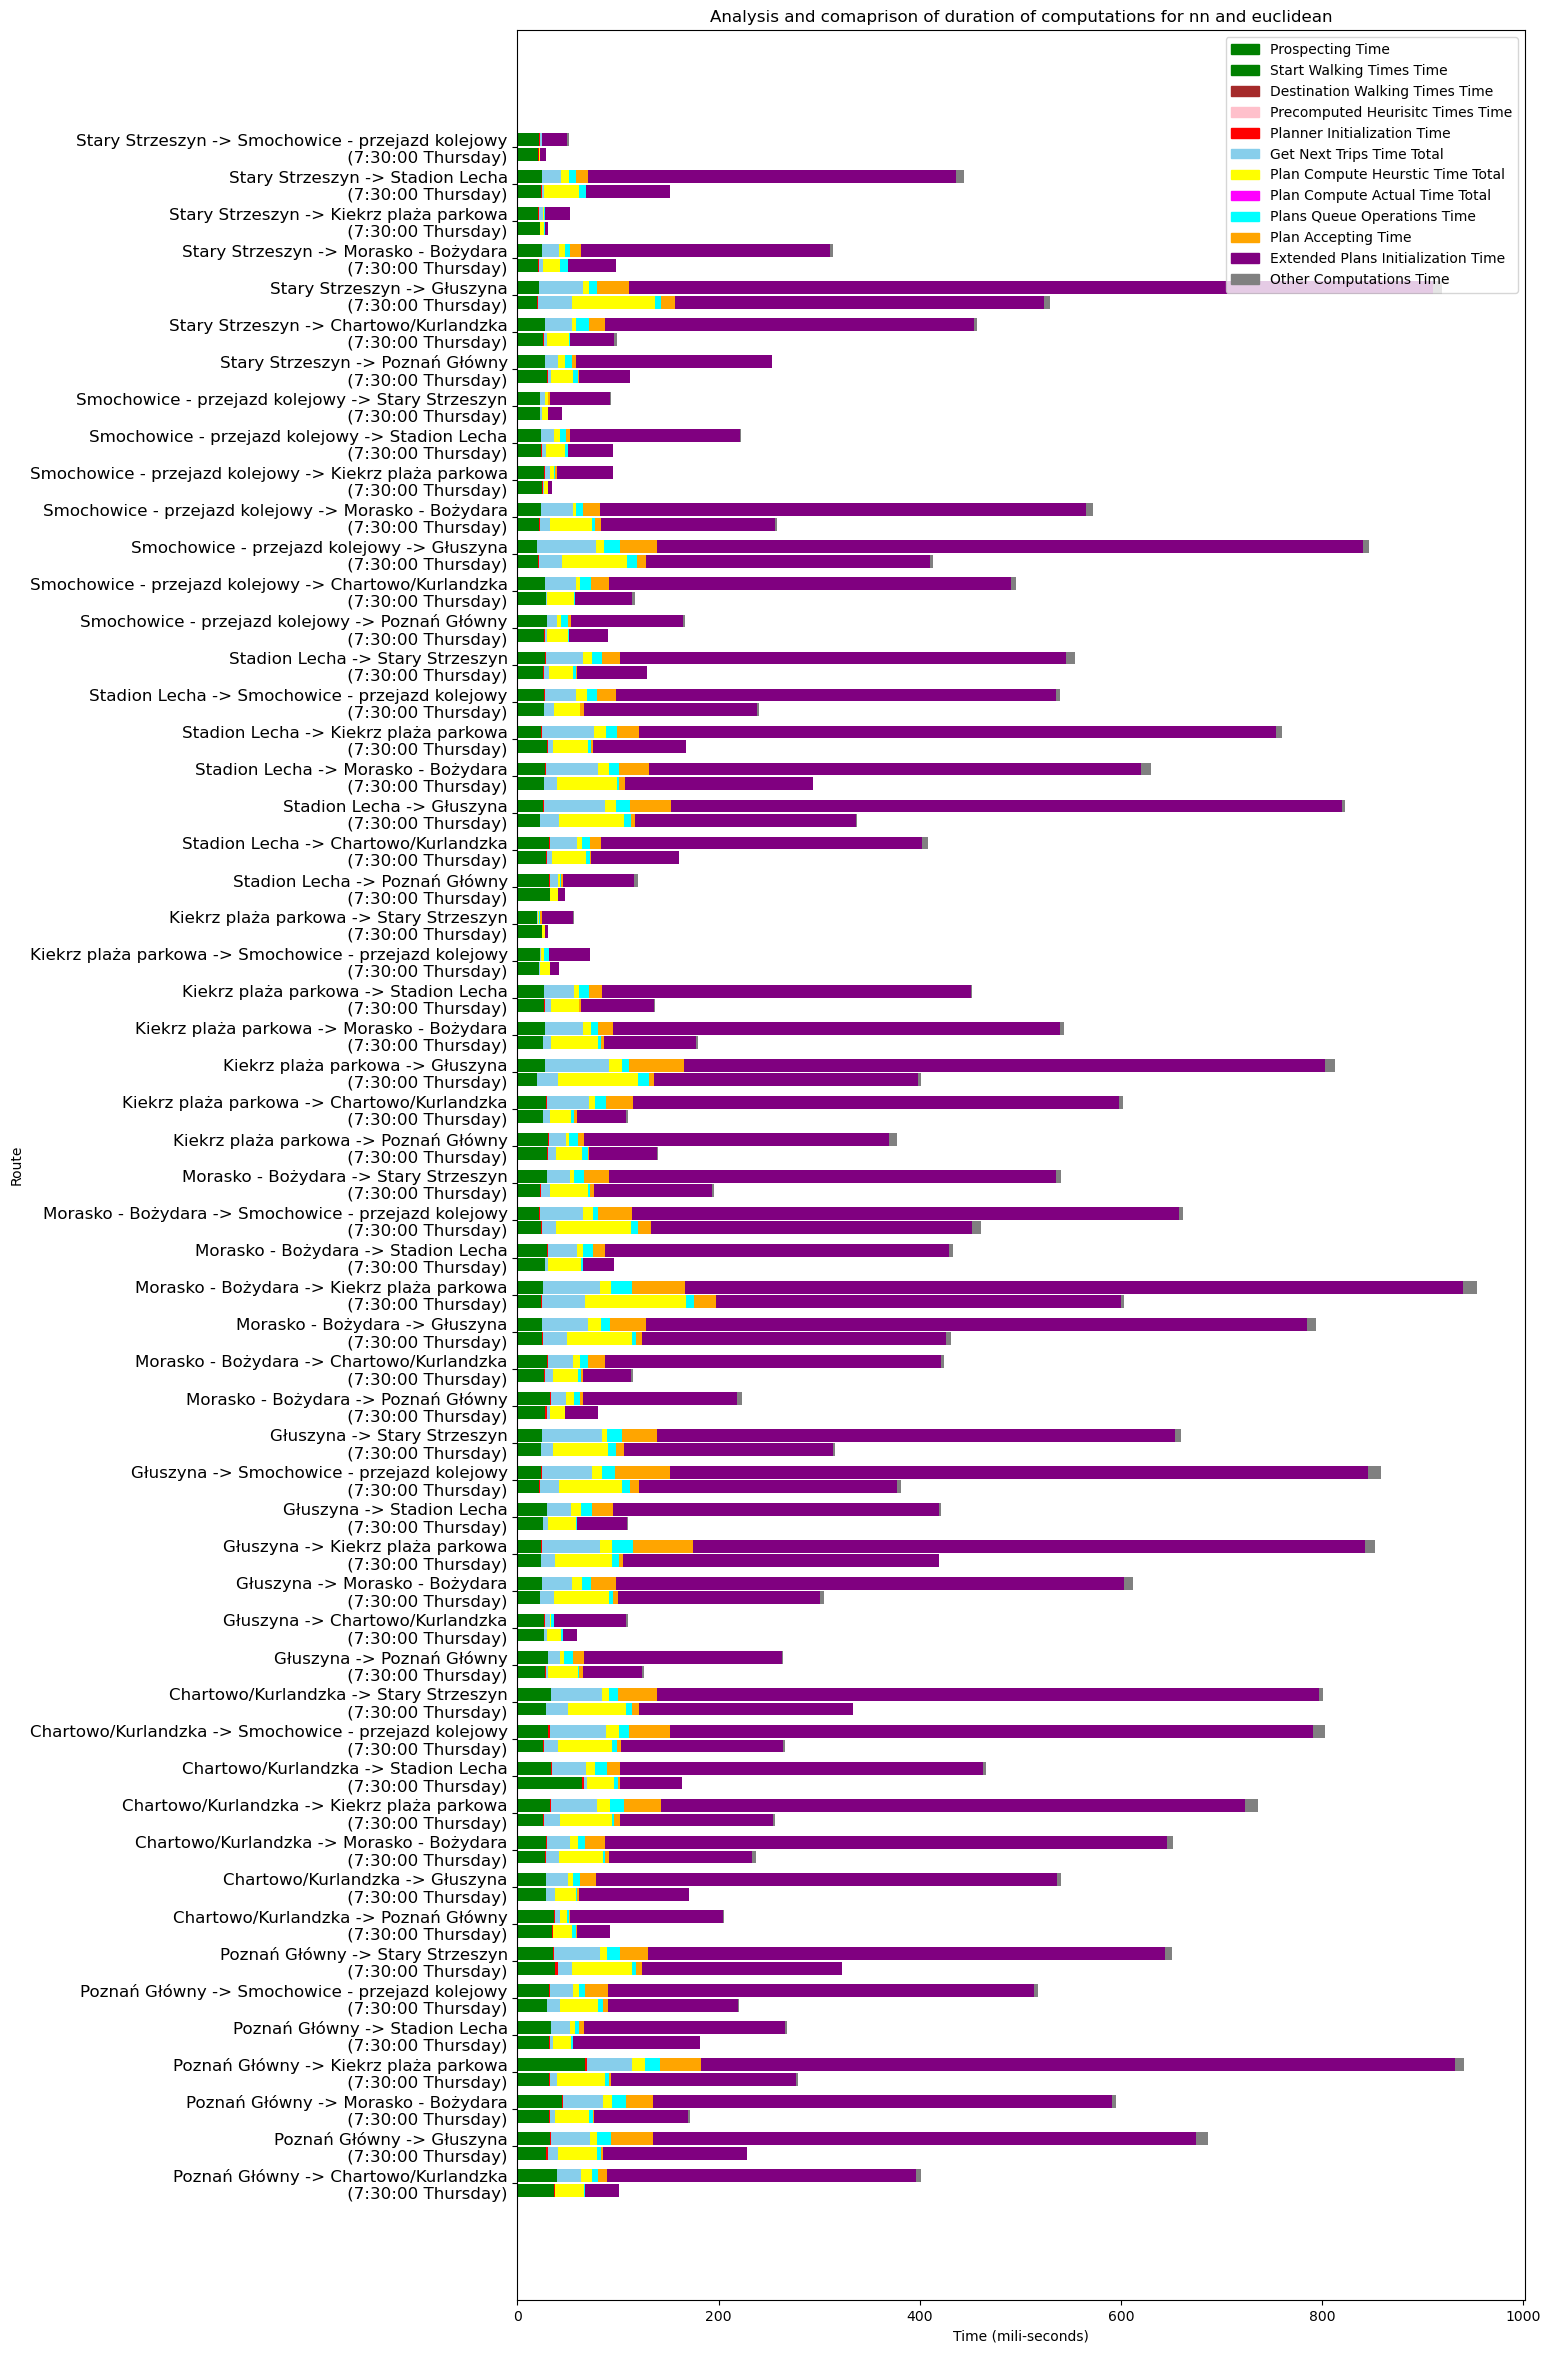

In [10]:
columns = [
    'prospecting_time',
    'start_walking_times_time',
    'destination_walking_times_time',
    'precomputed_heurisitc_times_time',
    'planner_initialization_time',
    'get_next_trips_time_total',
    'plan_compute_heurstic_time_total',
    'plan_compute_actual_time_total',
    'plans_queue_operations_time',
    'plan_accepting_time',
    'extended_plans_initialization_time',
]

color_map = {
    'prospecting_time': 'green',
    'start_walking_times_time': 'green',
    'destination_walking_times_time': 'brown',
    'precomputed_heurisitc_times_time': 'pink',
    'planner_initialization_time': 'red',
    'get_next_trips_time_total': 'skyblue',
    'plan_compute_heurstic_time_total': 'yellow',
    'plan_compute_actual_time_total': 'magenta',
    'plans_queue_operations_time': 'cyan',
    'plan_accepting_time': 'orange',
    'extended_plans_initialization_time': 'purple',
    'other_computations_time': 'gray',
}

df1_columns = [c for c in columns if c in df1]
df2_columns = [c for c in columns if c in df2]

df1['other_computations_time'] = df1['find_plans_time_total'] - df1[df1_columns].sum(axis=1, skipna=True)
df2['other_computations_time'] = df2['find_plans_time_total'] - df2[df2_columns].sum(axis=1, skipna=True)

df1['other_computations_time'] = df1['other_computations_time'].apply(lambda x: max(x, 0))
df2['other_computations_time'] = df2['other_computations_time'].apply(lambda x: max(x, 0))

fig, ax = plt.subplots(figsize=(13, fig_height*2))

bar_width = 0.35
gap_between_benchmarks = 0.05
index = np.arange(len(df1))

bottom1 = pd.Series([0] * len(df1))
for column in columns:
    if column in df1:
        ax.barh([i - bar_width/2 - gap_between_benchmarks/2 for i in index], df1[column], bar_width, left=bottom1, color=color_map[column], label=column.replace('_', ' ').title() if column == columns[0] else "")
        bottom1 += df1[column]
ax.barh([i - bar_width/2 - gap_between_benchmarks/2 for i in index], df1['other_computations_time'], bar_width, left=bottom1, color=color_map['other_computations_time'], label='Other Computations Time' if 'other_computations_time' == columns[0] else "")

bottom2 = pd.Series([0] * len(df2))
for column in columns:
    if column in df2:
        ax.barh([i + bar_width/2 + gap_between_benchmarks/2 for i in index], df2[column], bar_width, left=bottom2, color=color_map[column], label=column.replace('_', ' ').title() if column == columns[0] else "")
        bottom2 += df2[column]
ax.barh([i + bar_width/2 + gap_between_benchmarks/2 for i in index], df2['other_computations_time'], bar_width, left=bottom2, color=color_map['other_computations_time'], label='Other Computations Time' if 'other_computations_time' == columns[0] else "")

plt.xlabel('Time (mili-seconds)')
plt.ylabel('Route')
plt.title(f'Analysis and comaprison of duration of computations for {benchmark_1_name} and {benchmark_2_name}')

handles = [plt.Rectangle((0,0),1,1, color=color_map[col]) for col in columns + ['other_computations_time']]
labels = [col.replace('_', ' ').title() for col in columns + ['other_computations_time']]
ax.legend(handles, labels)

ax.set_yticks(index)
ax.set_yticklabels(df1['Label'], fontsize=12)  # Increase the font size of the route labels

plt.show()

## Plans queue length comaprison

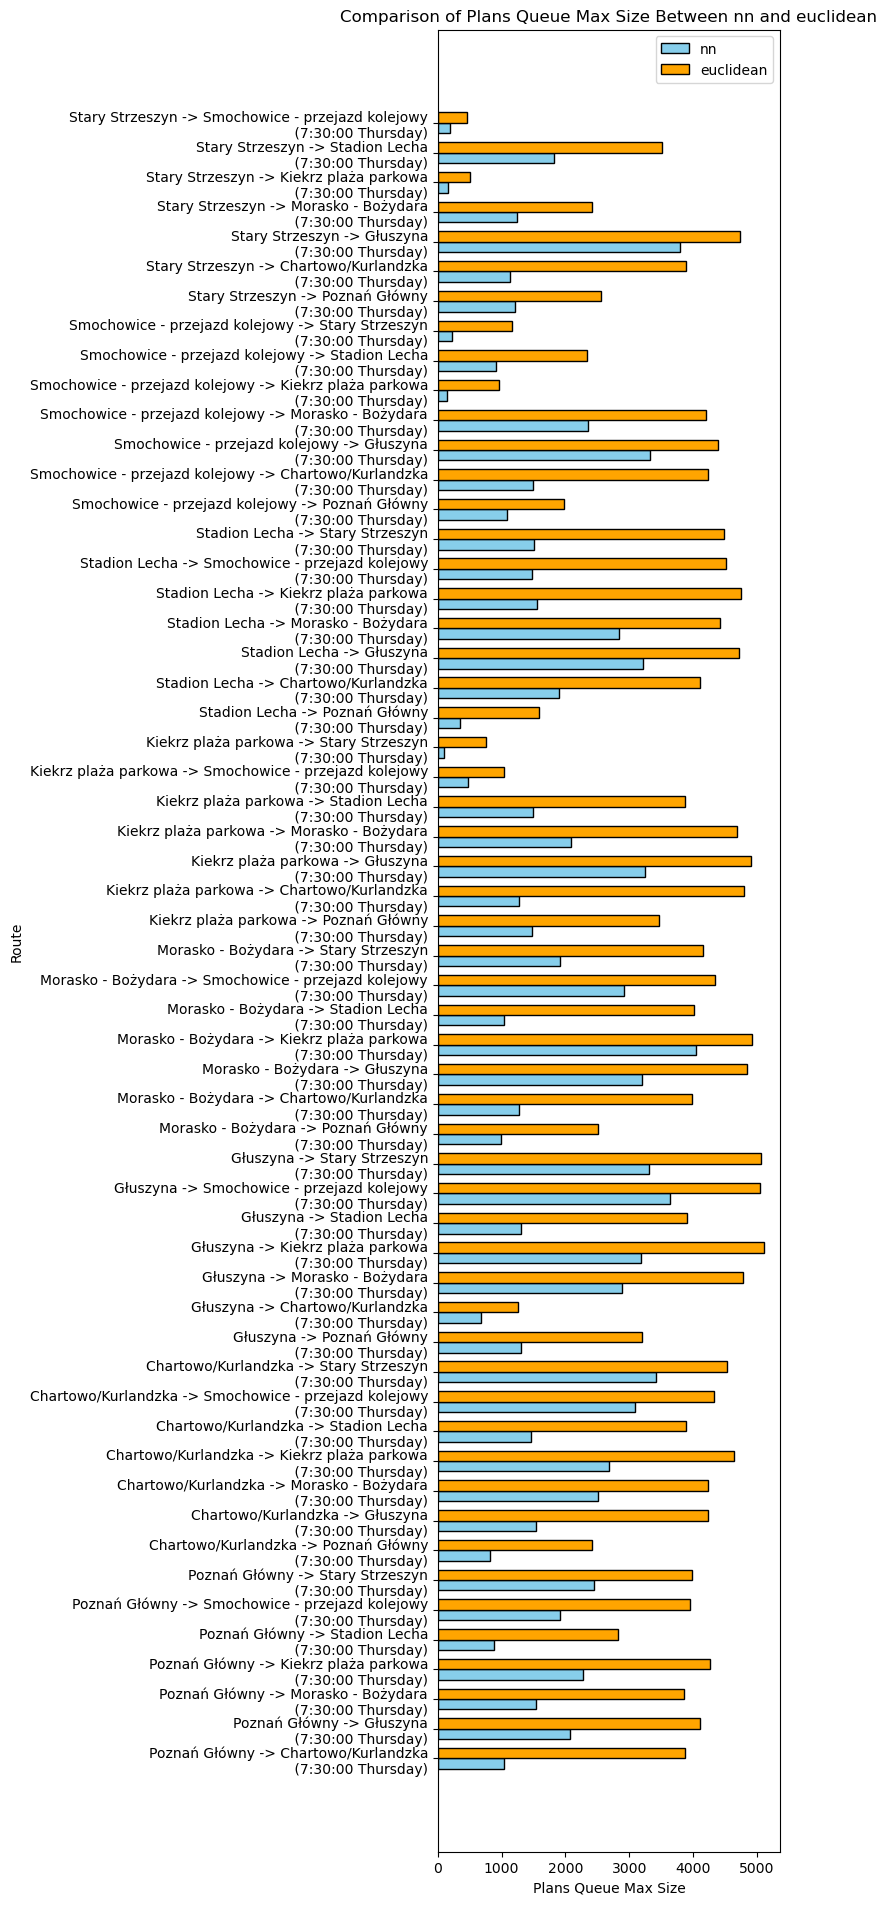

In [11]:
fig, ax = plt.subplots(figsize=(8, fig_height*1.3))

bar_width = 0.35
index = np.arange(len(df1))

bars1 = ax.barh(index - bar_width/2, df1['plans_queue_max_size'], bar_width, label=f'{benchmark_1_name}', color='skyblue', edgecolor='black')
bars2 = ax.barh(index + bar_width/2, df2['plans_queue_max_size'], bar_width, label=f'{benchmark_2_name}', color='orange', edgecolor='black')

ax.set_xlabel('Plans Queue Max Size')
ax.set_ylabel('Route')
ax.set_title(f'Comparison of Plans Queue Max Size Between {benchmark_1_name} and {benchmark_2_name}')
ax.set_yticks(index)
ax.set_yticklabels(df1['Label'])
ax.legend()

plt.tight_layout()
plt.show()

## Distribution of cost metrics

In [12]:
def plot_distribution_histogram(metric, title, xlabel):
    plt.figure(figsize=(14, 8))

    sns.histplot(df2[metric], color='orange', label=f'{benchmark_2_name}', stat="density", linewidth=0, alpha=0.3, bins=20)
    sns.histplot(df1[metric], color='skyblue', label=f'{benchmark_1_name}', stat="density", linewidth=0, alpha=0.4, bins = 20)

    sns.kdeplot(df2[metric], color='orange', lw=5)
    sns.kdeplot(df1[metric], color='skyblue', lw=5)

    median1 = df1[metric].median()
    mean1 = df1[metric].mean()
    plt.axvline(median1, color='skyblue', linestyle='--', linewidth=2, label=f'{benchmark_1_name} Median: {round(median1)}')
    plt.axvline(mean1, color='skyblue', linestyle='-', linewidth=2, label=f'{benchmark_1_name} Mean: {round(mean1)}')

    median2 = df2[metric].median()
    mean2 = df2[metric].mean()
    plt.axvline(median2, color='orange', linestyle='--', linewidth=2, label=f'{benchmark_2_name} Median: {round(median2)}')
    plt.axvline(mean2, color='orange', linestyle='-', linewidth=2, label=f'{benchmark_2_name} Mean: {round(mean2)}')

    plt.gca().set_yticklabels([])
    plt.xlim(left=0)
    plt.xlabel(xlabel)
    #plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

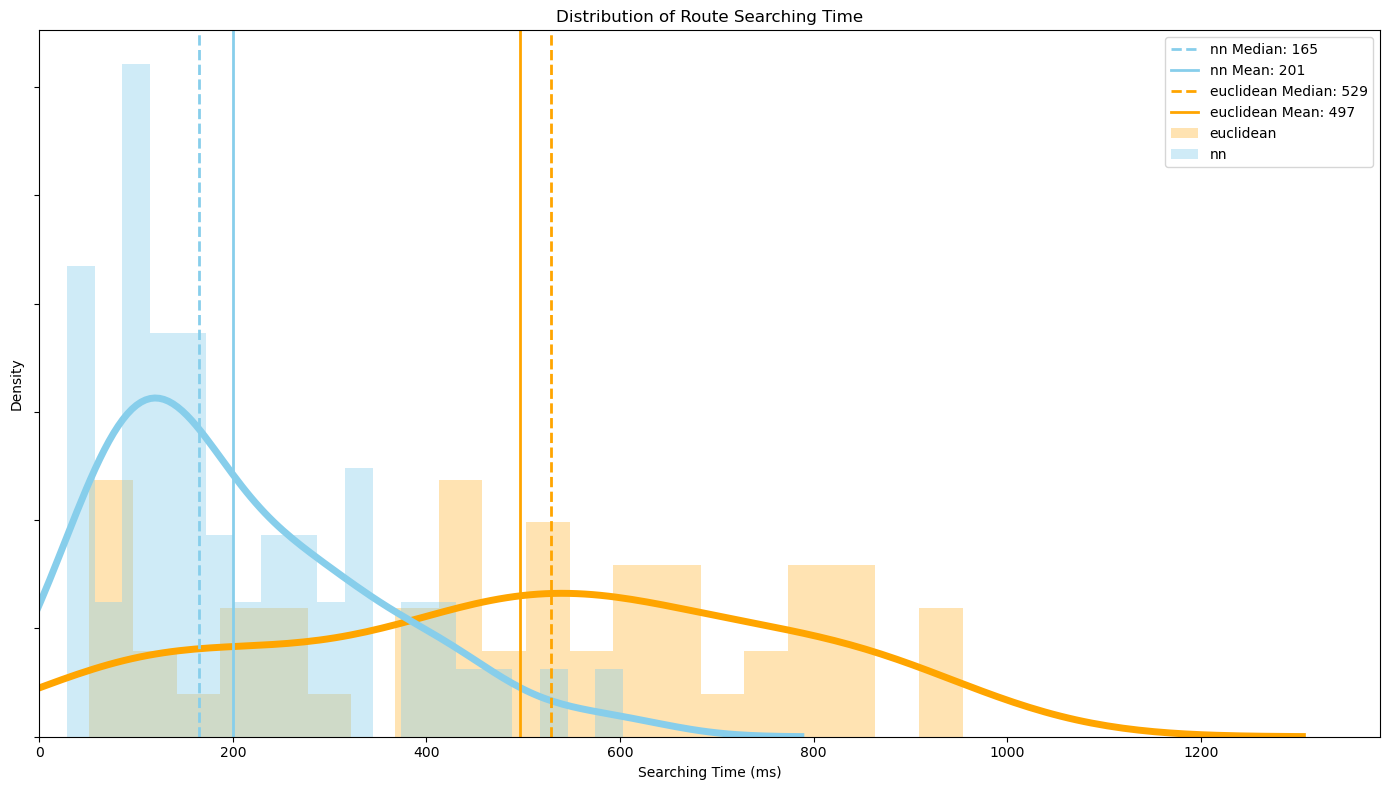

In [13]:
plot_distribution_histogram(
    metric='find_plans_time_total', 
    title='Distribution of Route Searching Time', 
    xlabel='Searching Time (ms)', 
)

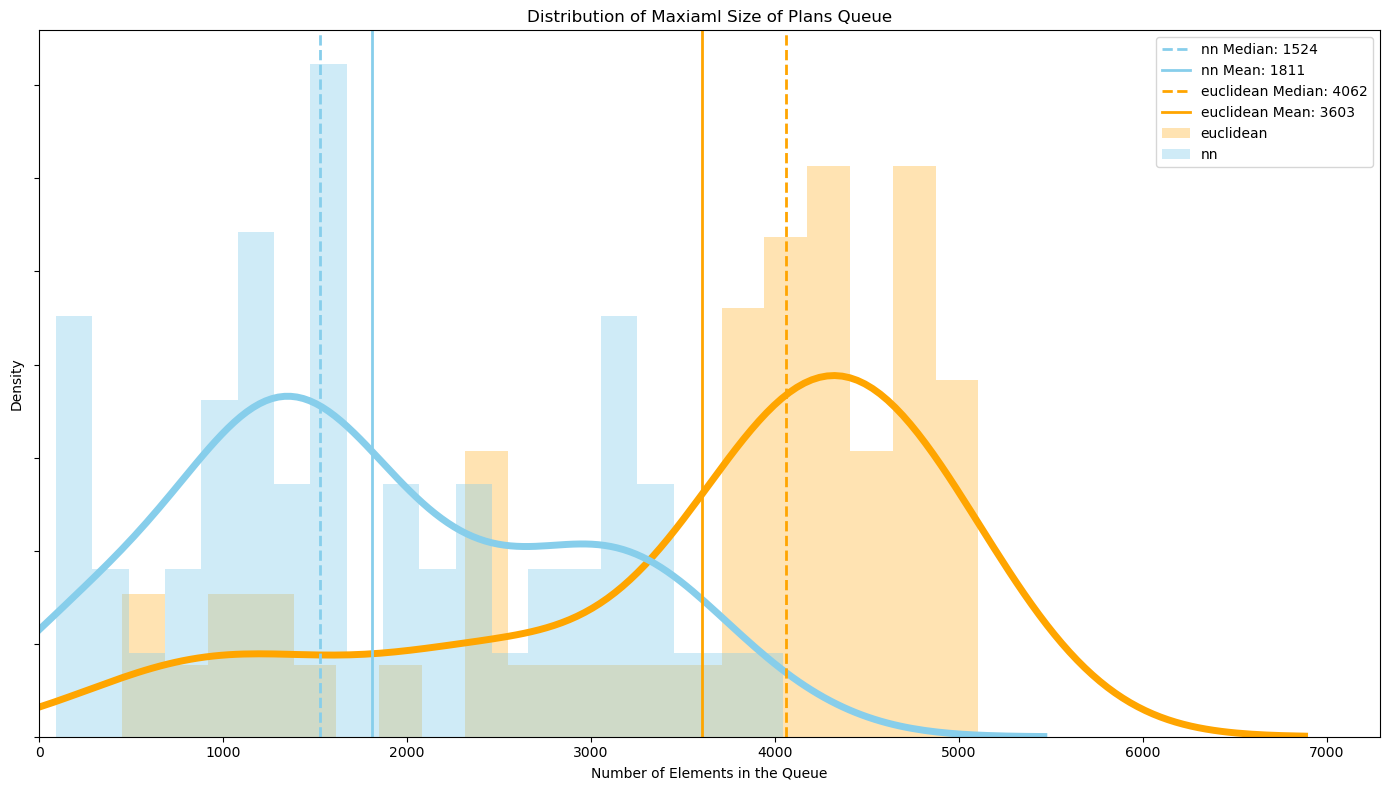

In [14]:
plot_distribution_histogram(
    metric='plans_queue_max_size', 
    title='Distribution of Maxiaml Size of Plans Queue', 
    xlabel='Number of Elements in the Queue', 
)

## Iterations

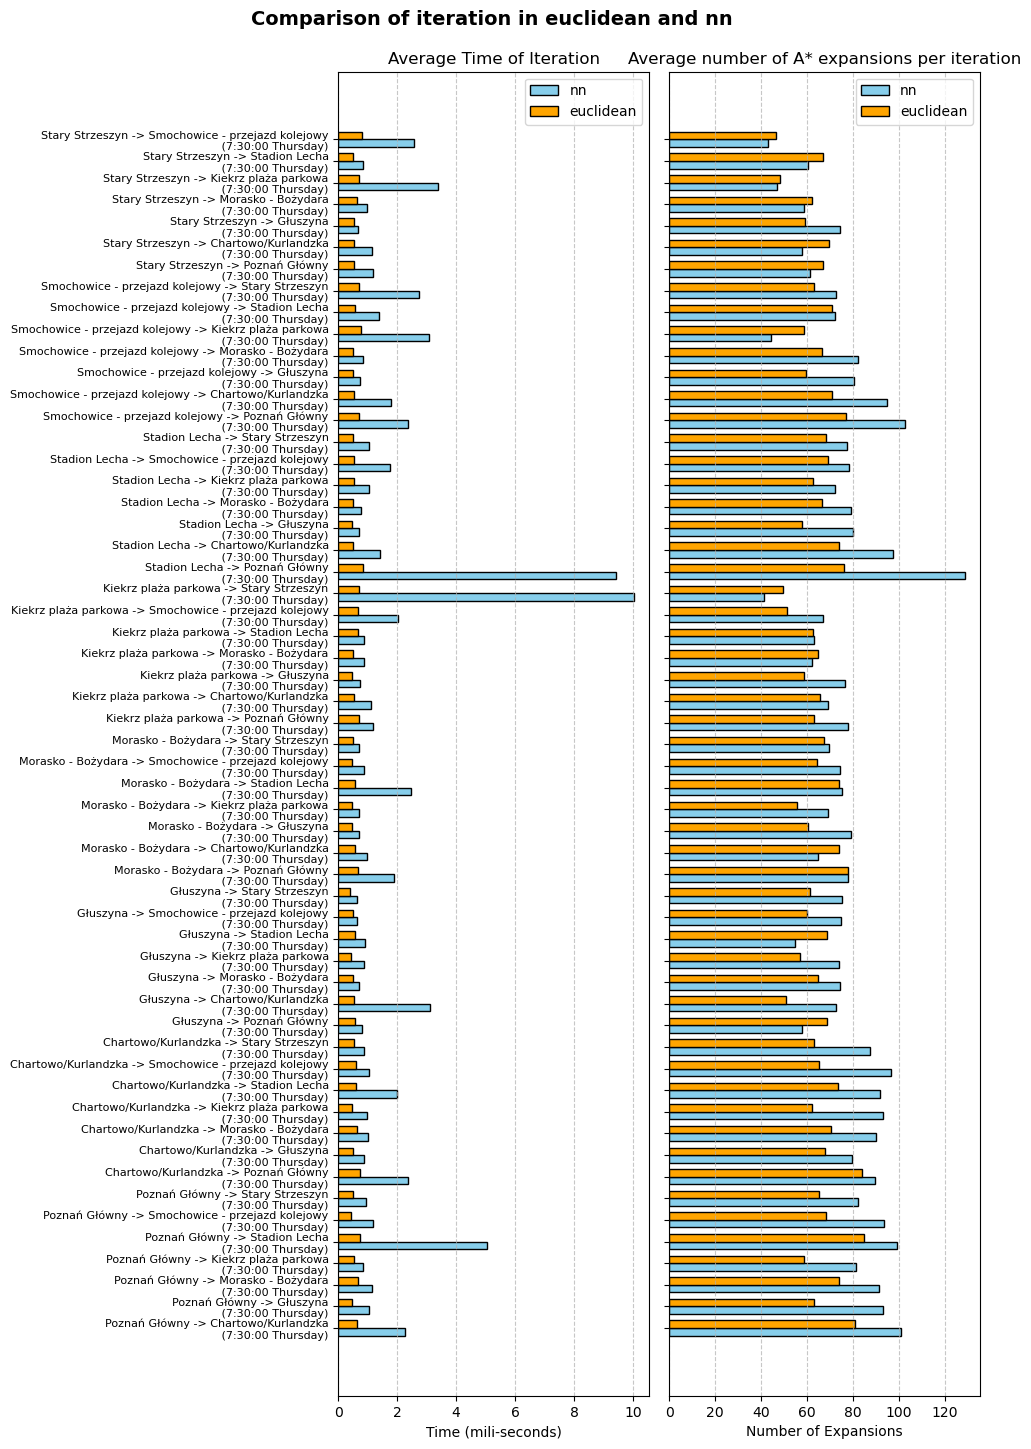

In [15]:
def plot_avg_per_iteration(metric_name_in_df, title, xlabel, ax):
    df1[f'{metric_name_in_df}_divided_by_no_iterations'] = df1[metric_name_in_df] / df1['iterations']
    df2[f'{metric_name_in_df}_divided_by_no_iterations'] = df2[metric_name_in_df] / df2['iterations']

    bar_width = 0.35
    index = np.arange(len(df1))

    bars1 = ax.barh(index - bar_width/2, df1[f'{metric_name_in_df}_divided_by_no_iterations'], bar_width, label=f'{benchmark_1_name}', color='skyblue', edgecolor='black')
    bars2 = ax.barh(index + bar_width/2, df2[f'{metric_name_in_df}_divided_by_no_iterations'], bar_width, label=f'{benchmark_2_name}', color='orange', edgecolor='black')

    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_yticks(index)
    ax.set_yticklabels(df1['Label'], fontsize=8)
    ax.legend()

    ax.grid(axis='x', linestyle='--', alpha=0.7)

fig, axes = plt.subplots(1, 2, figsize=(10, fig_height*1), sharey=True)

plot_avg_per_iteration(
    'find_plans_time_total',
    f'Average Time of Iteration', 
    'Time (mili-seconds)',
    ax=axes[0])

plot_avg_per_iteration(
    'expansions_total', 
    f'Average number of A* expansions per iteration', 
    'Number of Expansions',
    ax=axes[1])

fig.suptitle(f'Comparison of iteration in {benchmark_2_name} and {benchmark_1_name} \n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Saving analysis to PDF

In [16]:
def save_notebook():
   display(Javascript("IPython.notebook.save_checkpoint();"))
save_notebook()
notebook_filename = 'two_benchmarks_comparison.ipynb'
with open(notebook_filename) as f:
    nb = nbformat.read(f, as_version=4)

nb_copy = copy.deepcopy(nb)

nb_copy['cells'] = [cell for cell in nb_copy['cells'] if not (
    'tags' in cell['metadata'] and
    ('hide_all' in cell['metadata']['tags'] or 'hide_markdown' in cell['metadata']['tags'])
)]
for cell in nb_copy['cells']:
    if 'tags' in cell['metadata']:
        if 'hide_code' in cell['metadata']['tags']:
            cell['source'] = ''  # Clear the source to hide the input

html_exporter = HTMLExporter()
html_data, resources = html_exporter.from_notebook_node(nb_copy)

output_dir = 'data_analysis_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

html_filename = os.path.join(output_dir, filename + '.html')
with open(html_filename, 'w') as f:
    f.write(html_data)

print(f'Notebook has been converted to HTML and saved as {html_filename}')

<IPython.core.display.Javascript object>

Notebook has been converted to HTML and saved as data_analysis_results\nn_vs_euclidean_analysis.html
